#### Using GoogLeNet as a Classify All Model
Following GoogLeNet implementation from this [blog](https://ai.plainenglish.io/googlenet-inceptionv1-with-tensorflow-9e7f3a161e87)

Use GoogLeNet as a one-step classifier (all labels) for comparing with Yu paper models.  Data resized to 224x224 with 7x7 median filter applied, like the paper.  None type was also undersampled randomly to 30,000 samples (same random seed as implemented Yu paper detect model).

In [1]:
!pip install pickle5

In [2]:
# import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses, optimizers, callbacks, Model

import os
import time
import numpy as np
import pandas as pd

import helpers as helper
from keras_model_s3_wrapper import *

import boto3
import pickle5 as pickle
s3 = boto3.resource('s3')
bucket_name = 'wafer-capstone'
my_bucket = s3.Bucket(bucket_name)

In [3]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [4]:
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333) 
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True, gpu_options=gpu_options))

In [5]:
tf.__version__

'2.3.4'

In [6]:
tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
# specify variables for model
path = 'processed_data/WM-clean60'
result_path = 'results'

filename = 'WM-clean60'
option = '-all'
map_column = 'waferMap60'

model_id = 'googlenet'
data_id = 'all60'
note = '' # -optional

x = 60
y = 60

In [8]:
# load train, dev, and test sets
# directly from S3 (using boto3 resource)
start = time.time()

train_key = f'{path}/{filename}-train{option}.pkl'
dev_key = f'{path}/{filename}-dev.pkl'
test_key = f'{path}/{filename}-test.pkl'

train = pickle.loads(my_bucket.Object(train_key).get()['Body'].read())
dev = pickle.loads(my_bucket.Object(dev_key).get()['Body'].read())
test = pickle.loads(my_bucket.Object(test_key).get()['Body'].read())

print("Wall time: {:.2f} seconds".format(time.time() - start))
print(f"Train: {len(train)}")
print(f"Dev: {len(dev)}")
print(f"Test: {len(test)}")

print(f"Sanity check: {np.unique(train[map_column][0])}")

Wall time: 5.25 seconds
Train: 47863
Dev: 25942
Test: 25943
Sanity check: [0 1 2]


#### Quick EDA

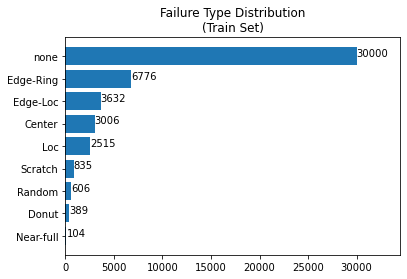

In [9]:
# train failure type distribution
helper.defect_distribution(train, note='Train Set')

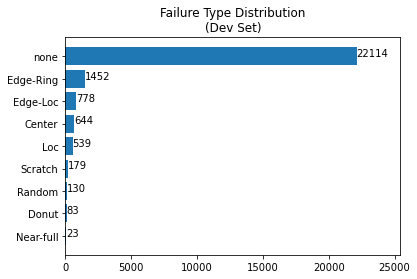

In [10]:
# dev failure type distribution
helper.defect_distribution(dev, note='Dev Set')

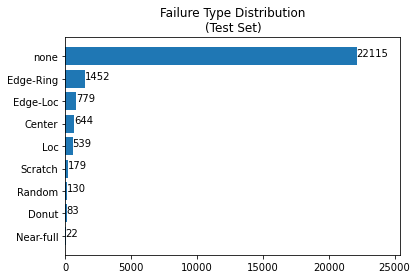

In [11]:
# test failure type distribution
helper.defect_distribution(test, note='Test Set')

#### Data set-up

In [12]:
# prepare inputs
start = time.time()

x_train = np.stack(train[map_column])
x_val = np.stack(dev[map_column])
x_test = np.stack(test[map_column])

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
# expected: (#rows, xdim, ydim)
print(x_train.shape)

Wall time: 0.23 seconds
(47863, 60, 60)


In [13]:
# expand tensor and repeat 3 times
# images in greyscale, so no channel dimension
start = time.time()

x_train = tf.expand_dims(x_train, axis=3, name=None)
x_val = tf.expand_dims(x_val, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
# expected: TensorShape([#rows, xdim, ydim, 3])
x_train.shape

Wall time: 0.36 seconds


TensorShape([47863, 60, 60, 1])

In [14]:
# expand tensor and repeat 3 times
# images in greyscale, so no channel dimension
start = time.time()

x_train = tf.repeat(x_train, 3, axis=3)
x_val = tf.repeat(x_val, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
# expected: TensorShape([#rows, xdim, ydim, 3])
x_train.shape

Wall time: 0.74 seconds


TensorShape([47863, 60, 60, 3])

In [15]:
# prepare labels for supervised learning
# note: make sure labels are integers if using sparse categorical cross entropy
start = time.time()

y_train = np.asarray(train['classifyLabels']).astype(np.uint8)
y_val = np.asarray(dev['classifyLabels']).astype(np.uint8)
y_test = np.asarray(test['classifyLabels']).astype(np.uint8)

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
# expected: type = int, min = 0, max = 7
print(type(y_train[0]))
print(min(y_train), min(y_val), min(y_test))
print(max(y_train), max(y_val), max(y_test))

Wall time: 0.00 seconds
<class 'numpy.uint8'>
0 0 0
8 8 8


#### Model

In [16]:
def inception(x,
              filters_1x1,
              filters_3x3_reduce,
              filters_3x3,
              filters_5x5_reduce,
              filters_5x5,
              filters_pool):
  path1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

  path2 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
  path2 = layers.Conv2D(filters_3x3, (1, 1), padding='same', activation='relu')(path2)

  path3 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
  path3 = layers.Conv2D(filters_5x5, (1, 1), padding='same', activation='relu')(path3)

  path4 = layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
  path4 = layers.Conv2D(filters_pool, (1, 1), padding='same', activation='relu')(path4)

  return tf.concat([path1, path2, path3, path4], axis=3)

In [17]:
inp = layers.Input(shape=(x, y, 3))
input_tensor = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=x_train.shape[1:])(inp)

x = layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(input_tensor)
x = layers.MaxPooling2D(3, strides=2)(x)

x = layers.Conv2D(64, 1, strides=1, padding='same', activation='relu')(x)
x = layers.Conv2D(192, 3, strides=1, padding='same', activation='relu')(x)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=64,
              filters_3x3_reduce=96,
              filters_3x3=128,
              filters_5x5_reduce=16,
              filters_5x5=32,
              filters_pool=32)

x = inception(x,
              filters_1x1=128,
              filters_3x3_reduce=128,
              filters_3x3=192,
              filters_5x5_reduce=32,
              filters_5x5=96,
              filters_pool=64)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=192,
              filters_3x3_reduce=96,
              filters_3x3=208,
              filters_5x5_reduce=16,
              filters_5x5=48,
              filters_pool=64)

aux1 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux1 = layers.Conv2D(128, 1, padding='same', activation='relu')(aux1)
aux1 = layers.Flatten()(aux1)
aux1 = layers.Dense(1024, activation='relu')(aux1)
aux1 = layers.Dropout(0.7)(aux1)
aux1 = layers.Dense(10, activation='softmax')(aux1)

x = inception(x,
              filters_1x1=160,
              filters_3x3_reduce=112,
              filters_3x3=224,
              filters_5x5_reduce=24,
              filters_5x5=64,
              filters_pool=64)

x = inception(x,
              filters_1x1=128,
              filters_3x3_reduce=128,
              filters_3x3=256,
              filters_5x5_reduce=24,
              filters_5x5=64,
              filters_pool=64)

x = inception(x,
              filters_1x1=112,
              filters_3x3_reduce=144,
              filters_3x3=288,
              filters_5x5_reduce=32,
              filters_5x5=64,
              filters_pool=64)

aux2 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux2 = layers.Conv2D(128, 1, padding='same', activation='relu')(aux2)
aux2 = layers.Flatten()(aux2)
aux2 = layers.Dense(1024, activation='relu')(aux2)
aux2 = layers.Dropout(0.7)(aux2)
aux2 = layers.Dense(10, activation='softmax')(aux2)

x = inception(x,
              filters_1x1=256,
              filters_3x3_reduce=160,
              filters_3x3=320,
              filters_5x5_reduce=32,
              filters_5x5=128,
              filters_pool=128)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=256,
              filters_3x3_reduce=160,
              filters_3x3=320,
              filters_5x5_reduce=32,
              filters_5x5=128,
              filters_pool=128)

x = inception(x,
              filters_1x1=384,
              filters_3x3_reduce=192,
              filters_3x3=384,
              filters_5x5_reduce=48,
              filters_5x5=128,
              filters_pool=128)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.4)(x)
out = layers.Dense(9, activation='softmax')(x)

In [18]:
model = Model(inputs = inp, outputs = [out, aux1, aux2])

In [19]:
model.compile(optimizer='adam', loss=[losses.sparse_categorical_crossentropy, losses.sparse_categorical_crossentropy, losses.sparse_categorical_crossentropy], loss_weights=[1, 0.3, 0.3], metrics=['accuracy'])

In [20]:
history = model.fit(x_train, [y_train, y_train, y_train], validation_data=(x_val, [y_val, y_val, y_val]), batch_size=64, epochs=30)

Epoch 1/30
748/748 [==============================] - 130s 174ms/step - loss: 1.6413 - dense_4_loss: 1.0290 - dense_1_loss: 1.0310 - dense_3_loss: 1.0101 - dense_4_accuracy: 0.6893 - dense_1_accuracy: 0.6981 - dense_3_accuracy: 0.7024 - val_loss: 0.4768 - val_dense_4_loss: 0.3018 - val_dense_1_loss: 0.3073 - val_dense_3_loss: 0.2761 - val_dense_4_accuracy: 0.9224 - val_dense_1_accuracy: 0.9207 - val_dense_3_accuracy: 0.9236
Epoch 2/30
748/748 [==============================] - 134s 179ms/step - loss: 0.7503 - dense_4_loss: 0.4454 - dense_1_loss: 0.5537 - dense_3_loss: 0.4623 - dense_4_accuracy: 0.8610 - dense_1_accuracy: 0.8391 - dense_3_accuracy: 0.8605 - val_loss: 0.3946 - val_dense_4_loss: 0.2166 - val_dense_1_loss: 0.3653 - val_dense_3_loss: 0.2283 - val_dense_4_accuracy: 0.9313 - val_dense_1_accuracy: 0.9005 - val_dense_3_accuracy: 0.9250
Epoch 3/30
748/748 [==============================] - 136s 181ms/step - loss: 0.5732 - dense_4_loss: 0.3332 - dense_1_loss: 0.4388 - dense_3_los

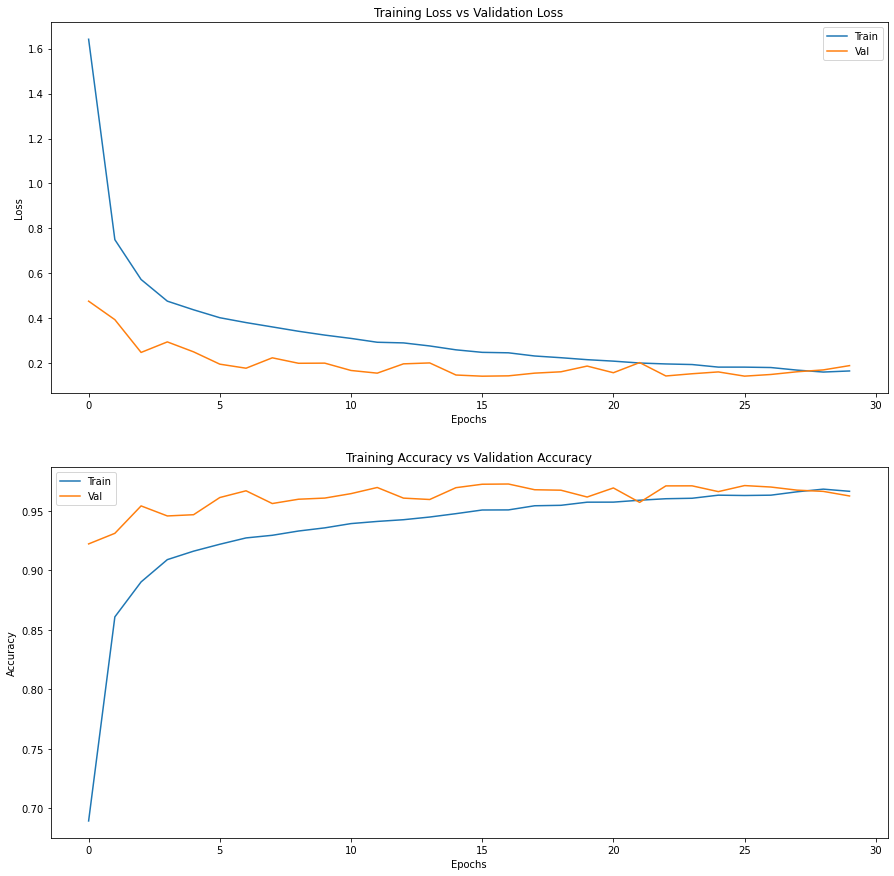

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history.history['dense_4_accuracy'])
axs[1].plot(history.history['val_dense_4_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

#### Model results

In [22]:
# save model to S3
s3_save_keras_model(model, f'{model_id}-{data_id}{note}')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpfosqd5uv/googlenet-all60/assets


In [23]:
# compute model results on test set
start = time.time()
results = model.evaluate(x_test, y_test)
print("Wall time: {:.2f} seconds".format(time.time() - start))
print(results)

811/811 [==============================] - 20s 25ms/step - loss: 0.1825 - dense_4_loss: 0.1099 - dense_1_loss: 0.1273 - dense_3_loss: 0.1146 - dense_4_accuracy: 0.9645 - dense_1_accuracy: 0.9587 - dense_3_accuracy: 0.9613
Wall time: 21.27 seconds
[0.1824655830860138, 0.10989189147949219, 0.12729960680007935, 0.11461308598518372, 0.9644991159439087, 0.9587171673774719, 0.9612612128257751]


In [24]:
# generate predictions for model analysis
start = time.time()
pred = model.predict(x_test)
y_pred = np.argmax(pred[0], axis=1)
predictions = [y_pred, pred]
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 18.611931800842285 seconds


In [25]:
# save predictions
# save to local instance
with open(f'{result_path}/{model_id}-{data_id}{note}.pkl', "wb") as f:
    pickle.dump(predictions, f)

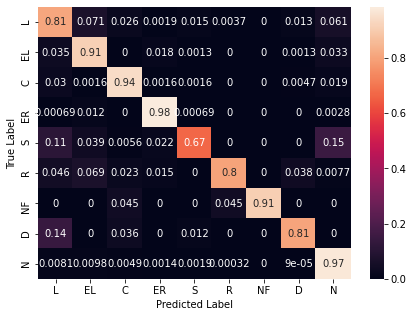

In [26]:
# plot confusion matrix
helper.plot_confusion_matrix(y_test, y_pred, mode='all', normalize=True)

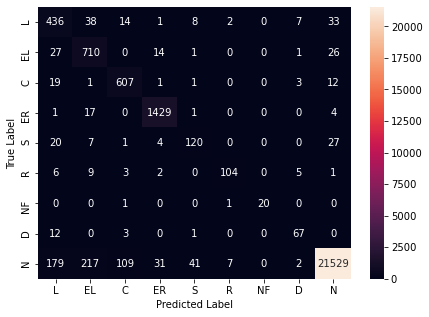

In [27]:
# plot confusion matrix counts
helper.plot_confusion_matrix(y_test, y_pred, mode='all', normalize=False)